<img src="../images/vegan-logo-resized.png" style="float: right; margin: 10px;">

# Preprocessing and Feature Engineering

Author: Gifford Tompkins

---

Project 03 | Notebook 3 of 6

## Objective
In this notebook, we will play with some models and some feature engineering.

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import time
import regex as re

from project_python_code import clean_string, parse_performance
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

In [2]:
model_scores = []

In [3]:
df = pd.read_csv('../datasets/model_data.csv')

In [4]:
df.head()

,title,selftext,vegan,text
0,Vegans who chastise &amp; disparage vegetarian...,Hey guys! As a long-time vegetarian who is now...,0,vegan who chastise disparage vegetarian are ...
1,I made breakfast pizza to imitate the Schwans ...,NaN,0,i made breakfast pizza to imitate the schwans ...
2,Know Your Nightshades,NaN,0,know your nightshade
3,After ten years of vegetarianism I just discov...,"This is my first time posting on this sub, I l...",0,after ten year of vegetarianism i just discove...
4,What's for Dinner? Discussion,Welcome to our weekly discussion on what you’r...,0,what ha for dinner discussion welcome to our ...


In [11]:
bf = df[['text','vegan']]
bf['avg_word_len'] = bf['text'].map(lambda x: np.mean([len(word) for word in x.split()]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
bf['word_count'] = bf['text'].map(lambda x: len(x.split()))

In [20]:
bf.groupby(by='vegan').agg([np.mean,np.std]).T

vegan                      0          1
avg_word_len mean   4.628417   4.546994
             std    0.957720   3.894840
word_count   mean  55.108450  46.717409
             std   84.250211  93.634953

In [24]:
X = df['text']
y = df['vegan']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

### Okay get to work.

In [7]:
from sklearn.model_selection import GridSearchCV
from project_python_code import parse_performance

In [8]:
def condenser(sparse_matrix):
    return sparse_matrix.toarray()

from sklearn.preprocessing import FunctionTransformer

condenser = FunctionTransformer(condenser, validate=False)

In [12]:
def run_evaluat_grid(grid, models=model_scores, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    model = {}
    t_0 = time.time()
    
    grid.fit(X_train, y_train)
    
    model['steps'] = [type(step) for _,step in grid.estimator.steps]
    model['best_cross_val'] = grid.best_score_
    model['best_params'] = grid.best_params_
    model['train_score'] = grid.score(X_train, y_train)
    model['test_score'] = grid.score(X_test, y_test)
    model['sensitivity'],model['specificity'],model['confusion_matrix'] = parse_performance(grid, X_test, y_test)
    model['runtime'] = time.time() - t_0
    
    return model

In [13]:
pipe_cv = Pipeline([
    ('vec',CountVectorizer()),
    ('estimator', MultinomialNB())
])

pipe_params = {
    'vec__max_features':[1000, 1100],
    'vec__min_df':[2, 3],
    'vec__max_df':[0.90, 0.95],
    'vec__stop_words': [None, 'english'],
    'vec__ngram_range': [(1,1), (1,2)]
}

gs_cv = GridSearchCV(pipe_cv,
                  pipe_params,
                  cv=5)

model_scores.append(run_evaluat_grid(gs_cv))
model_scores[-1]

Model Score: 0.7376509330406147
Model sensitivity: 0.6737704918032786
Model specificity: 0.8020948180815877


{'steps': [sklearn.feature_extraction.text.CountVectorizer,
  sklearn.naive_bayes.MultinomialNB],
 'best_cross_val': 0.7459518799743847,
 'best_params': {'vec__max_df': 0.9,
  'vec__max_features': 1000,
  'vec__min_df': 2,
  'vec__ngram_range': (1, 2)},
 'train_score': 0.7524471686030555,
 'test_score': 0.7376509330406147,
 'sensitivity': 0.6737704918032786,
 'specificity': 0.8020948180815877,
 'confusion_matrix': (1455, 359, 597, 1233),
 'runtime': 92.63815593719482}

## TFID Vectorizer and Gaussian NB

In [14]:
pipe_tf = Pipeline([
    ('vec',TfidfVectorizer()),
    ('condenser', condenser),
    ('estimator', GaussianNB())
])

pipe_params = {
    'vec__max_features':[1000, 1100],
    'vec__min_df':[2, 3],
    'vec__stop_words':[None,'english'],
    'vec__max_df':[0.90, 0.95],
    'vec__ngram_range': [(1,1), (1,2)]
}

gs_tf = GridSearchCV(pipe_tf,
                  pipe_params,
                  cv=5
                 )

model_scores.append(run_evaluat_grid(gs_tf))
model_scores[-1]

Model Score: 0.7088364434687157
Model sensitivity: 0.7060109289617487
Model specificity: 0.7116868798235942


{'steps': [sklearn.feature_extraction.text.TfidfVectorizer,
  sklearn.preprocessing._function_transformer.FunctionTransformer,
  sklearn.naive_bayes.GaussianNB],
 'best_cross_val': 0.7173177202451743,
 'best_params': {'vec__max_df': 0.9,
  'vec__max_features': 1000,
  'vec__min_df': 2,
  'vec__ngram_range': (1, 2),
  'vec__stop_words': None},
 'train_score': 0.7562894520171988,
 'test_score': 0.7088364434687157,
 'sensitivity': 0.7060109289617487,
 'specificity': 0.7116868798235942,
 'confusion_matrix': (1291, 523, 538, 1292),
 'runtime': 235.22822618484497}

## Count Vectorizer and Logistic Regression 

In [17]:
from sklearn.linear_model import LogisticRegression

In [19]:
pipe_cv = Pipeline([
    ('vec',CountVectorizer()),
    ('estimator', LogisticRegression())
])

pipe_params = {
    'vec__max_features':[1000, 1100],
    'vec__min_df':[2, 3],
    'vec__max_df':[0.90, 0.95],
    'vec__stop_words': [None,'english'],
    'vec__ngram_range': [(1,1), (1,2)]
}

gs_cv = GridSearchCV(pipe_cv,
                  pipe_params,
                  cv=5)

model_scores.append(run_evaluat_grid(gs_cv))
model_scores[-1]

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Score: 0.7711306256860593
Model sensitivity: 0.8136612021857923
Model specificity: 0.7282249173098125


{'steps': [sklearn.feature_extraction.text.CountVectorizer,
  sklearn.linear_model.logistic.LogisticRegression],
 'best_cross_val': 0.776141249656939,
 'best_params': {'vec__max_df': 0.9,
  'vec__max_features': 1000,
  'vec__min_df': 2,
  'vec__ngram_range': (1, 1),
  'vec__stop_words': 'english'},
 'train_score': 0.8243527582105937,
 'test_score': 0.7711306256860593,
 'sensitivity': 0.8136612021857923,
 'specificity': 0.7282249173098125,
 'confusion_matrix': (1321, 493, 341, 1489),
 'runtime': 180.73202896118164}

## Tfid Vectorizer and Logistic Regression

In [20]:
pipe_cv = Pipeline([
    ('vec',TfidfVectorizer()),
    ('condenser', condenser),    
    ('estimator', LogisticRegression(solver='lbfgs'))
])

pipe_params = {
    'vec__max_features':[1000, 1100],
    'vec__min_df':[2, 3],
    'vec__max_df':[0.90, 0.95],
    'vec__stop_words': [None,'english'],
    'vec__ngram_range': [(1,1), (1,2)]
}

gs_cv = GridSearchCV(pipe_cv,
                  pipe_params,
                  cv=5)

model_scores.append(run_evaluat_grid(gs_cv))
model_scores[-1]

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Model Score: 0.7746981339187706
Model sensitivity: 0.7950819672131147
Model specificity: 0.7541345093715546


{'steps': [sklearn.feature_extraction.text.TfidfVectorizer,
  sklearn.preprocessing._function_transformer.FunctionTransformer,
  sklearn.linear_model.logistic.LogisticRegression],
 'best_cross_val': 0.7901381392370322,
 'best_params': {'vec__max_df': 0.9,
  'vec__max_features': 1000,
  'vec__min_df': 2,
  'vec__ngram_range': (1, 1),
  'vec__stop_words': None},
 'train_score': 0.8188637819046748,
 'test_score': 0.7746981339187706,
 'sensitivity': 0.7950819672131147,
 'specificity': 0.7541345093715546,
 'confusion_matrix': (1368, 446, 375, 1455),
 'runtime': 187.61285495758057}

# Benchmark: 
CountVectorizer and  MultinomialNaiveBayes Theorem giving us the best Specificity.

In [57]:
pd.DataFrame(model_scores).sort_values(by='specificity',ascending=False)

,steps,best_cross_val,best_params,train_score,test_score,sensitivity,specificity,confusion_matrix,runtime
0,[<class 'sklearn.feature_extraction.text.Count...,0.745952,"{'vec__max_df': 0.9, 'vec__max_features': 1000...",0.752447,0.737651,0.673770,0.802095,"(1455, 359, 597, 1233)",92.638156
1,[<class 'sklearn.feature_extraction.text.Count...,0.745952,"{'vec__max_df': 0.9, 'vec__max_features': 1000...",0.752447,0.737651,0.673770,0.802095,"(1455, 359, 597, 1233)",92.638156
4,[<class 'sklearn.feature_extraction.text.Tfidf...,0.790138,"{'vec__max_df': 0.9, 'vec__max_features': 1000...",0.818864,0.774698,0.795082,0.754135,"(1368, 446, 375, 1455)",187.612855
3,[<class 'sklearn.feature_extraction.text.Count...,0.776141,"{'vec__max_df': 0.9, 'vec__max_features': 1000...",0.824353,0.771131,0.813661,0.728225,"(1321, 493, 341, 1489)",180.732029
2,[<class 'sklearn.feature_extraction.text.Tfidf...,0.717318,"{'vec__max_df': 0.9, 'vec__max_features': 1000...",0.756289,0.708836,0.706011,0.711687,"(1291, 523, 538, 1292)",235.228226
5,[<class 'sklearn.feature_extraction.text.Count...,0.771659,{},0.780807,0.770307,0.840437,0.699559,"(1269, 545, 292, 1538)",116.088183


In [61]:
model_scores

[{'steps': [sklearn.feature_extraction.text.CountVectorizer,
   sklearn.naive_bayes.MultinomialNB],
  'best_cross_val': 0.7459518799743847,
  'best_params': {'vec__max_df': 0.9,
   'vec__max_features': 1000,
   'vec__min_df': 2,
   'vec__ngram_range': (1, 2),
   'vec__stop_words': None},
  'train_score': 0.7524471686030555,
  'test_score': 0.7376509330406147,
  'sensitivity': 0.6737704918032786,
  'specificity': 0.8020948180815877,
  'confusion_matrix': (1455, 359, 597, 1233),
  'runtime': 92.63815593719482},
 {'steps': [sklearn.feature_extraction.text.CountVectorizer,
   sklearn.naive_bayes.MultinomialNB],
  'best_cross_val': 0.7459518799743847,
  'best_params': {'vec__max_df': 0.9,
   'vec__max_features': 1000,
   'vec__min_df': 2,
   'vec__ngram_range': (1, 2)},
  'train_score': 0.7524471686030555,
  'test_score': 0.7376509330406147,
  'sensitivity': 0.6737704918032786,
  'specificity': 0.8020948180815877,
  'confusion_matrix': (1455, 359, 597, 1233),
  'runtime': 92.63815593719482}

## SVD the data

In [26]:
from sklearn.decomposition import TruncatedSVD

In [27]:
component_num = 2000

In [46]:
tfid = TfidfVectorizer(stop_words='english', min_df=5, max_df=1.0)
X_tf = tfid.fit_transform(X, y)

In [47]:
SVD = TruncatedSVD(n_components=component_num)
svd_matrix = SVD.fit_transform(X_tf)
svd_matrix.shape

(14575, 2000)

In [48]:
SVD.components_.shape

(2000, 5493)

Text(0.5, 1.0, 'Explained variance by component')

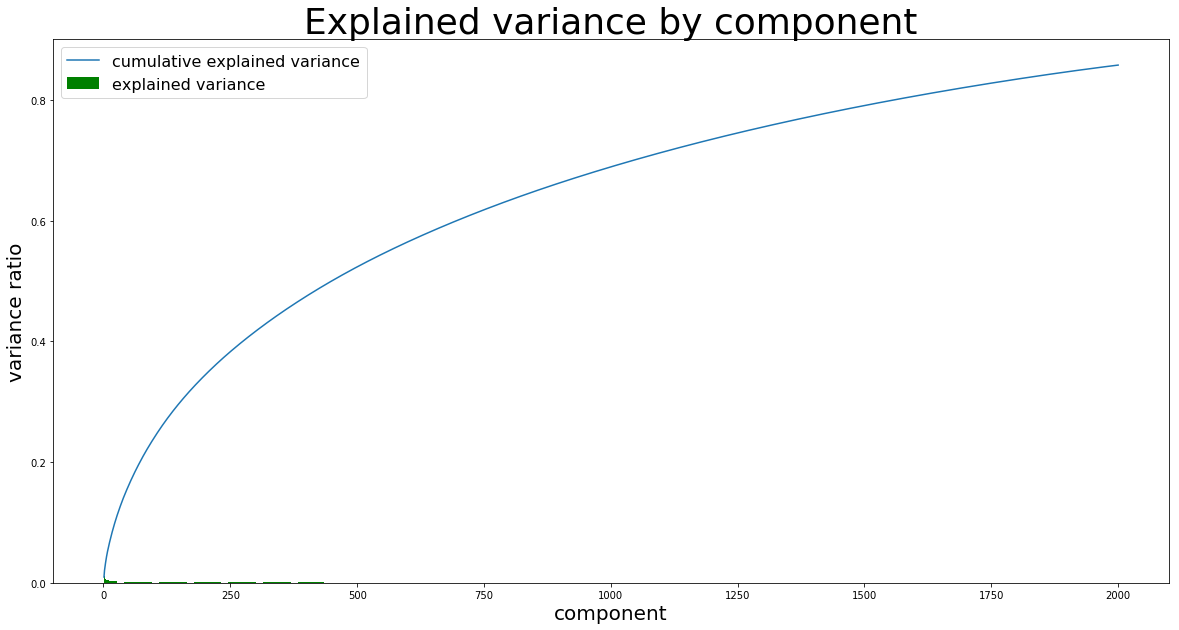

In [49]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(component_num))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(component_num))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend(fontsize=16)
plt.xlabel('component', fontsize=20)
plt.ylabel('variance ratio', fontsize=20)
plt.title('Explained variance by component', fontsize=36)

In [32]:
np.cumsum(SVD.explained_variance_ratio_)[3000]

IndexError: index 3000 is out of bounds for axis 0 with size 2000

In [50]:
np.where(np.cumsum(SVD.explained_variance_ratio_) < .75)[0][-1]+1

1271

In [51]:
svd_matrix.shape

(14575, 2000)

In [52]:
SVD.components_.shape

(2000, 5493)

In [53]:
svd_df = pd.DataFrame(SVD.components_,columns=tfid.get_feature_names())

In [54]:
svd_df['vegan_target'] = y

In [55]:
svd_df

,00,000,01,03,04,05,06,07,08,09,...,yumm,yummy,zaatar,zealand,zero,zinc,zone,zoo,zucchini,vegan_target
0,0.000394,0.002594,0.000294,0.000236,0.000533,0.000208,0.000344,0.000286,0.000542,0.001635,...,0.000175,0.008292,0.000262,0.000693,0.003122,0.000748,0.001142,0.001027,0.004208,0
1,-0.000058,0.000083,-0.000295,-0.000131,-0.000407,-0.000049,-0.000036,0.000068,-0.000303,0.000717,...,-0.000162,-0.004979,-0.000205,-0.000036,-0.000221,-0.000165,0.000088,-0.000068,-0.002280,0
2,0.000475,-0.001793,0.000226,0.000286,-0.001022,0.000752,-0.000290,0.000230,0.001358,0.001069,...,0.000373,-0.008062,0.000696,-0.000144,-0.001185,0.000204,0.000431,-0.001002,0.013276,0
3,0.000903,-0.000675,-0.000058,0.000213,-0.000219,0.000870,-0.000007,0.000420,0.000359,0.002269,...,0.001339,0.027215,0.001150,-0.000004,-0.000231,-0.000008,0.000701,-0.000785,0.014063,0
4,-0.000008,-0.003298,0.000469,-0.000520,-0.000234,-0.000520,-0.000273,-0.000636,0.000364,-0.001909,...,-0.000715,0.017148,-0.000962,0.000100,-0.003579,-0.001273,-0.001285,-0.002149,-0.005664,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.009450,0.033436,0.003257,0.002318,0.006145,0.002757,0.007763,0.005262,0.004140,-0.026663,...,-0.000754,0.000527,-0.000167,0.011249,-0.005128,-0.006428,-0.005106,-0.008143,-0.001546,0
1996,-0.002100,-0.000032,-0.001246,-0.001643,0.005736,-0.002036,-0.011378,-0.001221,-0.007997,0.001016,...,0.001950,-0.000971,0.029367,0.006384,-0.016241,0.003194,-0.010520,0.031718,-0.004526,0
1997,0.003349,0.021499,0.004245,0.000653,0.004094,0.002331,-0.008410,-0.000569,-0.002544,-0.000257,...,0.001188,-0.000278,-0.014299,0.036773,-0.034936,0.000820,0.016948,-0.012265,-0.005863,0
1998,0.001179,-0.001753,0.002048,0.004455,0.010092,0.000071,-0.015246,0.005951,-0.007363,0.004222,...,-0.003307,-0.002266,0.002720,0.002443,0.001945,-0.003318,-0.008552,-0.025241,-0.000181,0


In [44]:
filename = '../datasets/svd_term_matrix.csv'
svd_df.to_csv(filename,index_label='tokens')
pd.read_csv(filename,index_col='tokens')

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
tokens,,,,,,,,,,,,,,,,,,,,,
00,0.000336,-0.000097,0.000632,0.000545,-0.000355,-0.000563,-0.000674,-0.000430,0.000443,0.000216,...,-0.004843,-0.002206,-0.004793,-0.002433,-0.012026,0.002034,-0.005652,-0.008028,-0.009262,-0.014090
000,0.002700,-0.000236,-0.001408,-0.000435,-0.004030,0.002304,0.000193,0.002019,0.000038,-0.000645,...,0.010709,0.018770,-0.025502,0.010636,-0.005163,-0.004300,0.007747,0.010708,-0.025544,-0.000724
04,0.000587,-0.000418,-0.001228,-0.000460,-0.000327,-0.000286,-0.000352,0.001853,-0.000772,-0.000194,...,-0.001261,0.006223,0.000265,0.005762,0.007517,-0.006264,-0.001373,0.017166,-0.001820,0.010064
05,0.000212,-0.000067,0.000618,0.000908,-0.000423,-0.001232,-0.000923,0.002395,-0.000006,0.000228,...,-0.000561,0.006066,-0.000530,-0.004314,-0.005017,-0.003795,-0.005548,0.006707,-0.007339,0.004094
06,0.000323,-0.000190,-0.000343,-0.000080,-0.000095,-0.000202,-0.000411,0.000915,0.000180,-0.000430,...,-0.006530,0.000206,0.002835,-0.006522,-0.005202,-0.000951,-0.001551,-0.009458,-0.004867,-0.007505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zero,0.002840,-0.000459,-0.001366,-0.000254,-0.003389,0.000962,-0.000016,0.000509,-0.000024,-0.001523,...,0.007164,0.007387,-0.020459,-0.014969,0.031816,-0.025531,-0.062668,-0.027460,-0.012588,0.001343
zinc,0.000945,-0.000202,0.000064,0.000193,-0.001696,0.000315,0.000231,-0.000998,0.000931,0.000658,...,0.004852,0.007890,0.004357,-0.003778,0.013582,-0.016782,0.007484,-0.007842,0.000939,0.007322
zone,0.000698,0.000071,0.000029,0.000565,-0.000661,-0.000603,-0.000717,0.002662,0.000444,0.001009,...,0.008611,-0.009273,-0.010725,-0.007299,0.003019,0.001862,-0.014611,-0.000361,-0.006192,0.001477


In [132]:
pipe_cv = Pipeline([
    ('vec',TfidfVectorizer()),
    ('condenser', condenser),
    ('svd',TruncatedSVD(n_components=component_num)),
    ('estimator', LogisticRegression(solver='lbfgs'))
])

pipe_params = {
#     'vec__max_features':[1000, 1100],
    'vec__min_df':[2, 5],
    'vec__max_df':[0.90, 0.95],
    'vec__stop_words': [None,'english'],
    'vec__ngram_range': [(1,1), (1,2)]
}

gs_cv = GridSearchCV(pipe_cv,
                  pipe_params,
                  cv=5)

model_scores.append(run_evaluat_grid(gs_cv))
model_scores[-1]

KeyboardInterrupt: 

# Summary
This notebook can probably be excluded or included within another notebook. In the next notebook we will systematically run through every model we are interested in trying.